### Βήμα 0: Imports και αρχικές ρυθμίσεις
Απαραίτητα imports, βασικές παράμετροι, paths αρχείων και οι ρυθμίσεις για το Elasticsearch.

In [1]:
import pandas as pd
import json
from pathlib import Path
from tqdm import tqdm
import html
import re
import requests
from elasticsearch import Elasticsearch
import sys
from collections import defaultdict

# --- Global Parameters ---

# Directories
CWD = Path.cwd()
DATA_DIR = CWD / "data"
RESULTS_DIR = CWD

# Elasticsearch settings
ES_HOST = "http://localhost:9200"
ES_INDEX = "ir2025_bm25"  # Updated to use BM25 index

# Input files
DOCUMENTS_CSV = DATA_DIR / "documents.csv"
QUERIES_CSV = DATA_DIR / "queries.csv"
QRELS_FILE = DATA_DIR / "qrels.txt"

# Output files
DOCUMENTS_NDJSON = DATA_DIR / "documents.ndjson"

# Evaluation parameters
K_VALUES_RUN = [20, 30, 50]
K_VALUES_EVAL = [5, 10, 15, 20]

print("✓ Paths and parameters configured.")
print(f"Data directory: {DATA_DIR}")
print(f"Results directory: {RESULTS_DIR}")
print(f"Elasticsearch Index: {ES_INDEX}")


✓ Paths and parameters configured.
Data directory: c:\Users\User\Downloads\IR2025\IR2025\data
Results directory: c:\Users\User\Downloads\IR2025\IR2025
Elasticsearch Index: ir2025_bm25


# Φάση 1 -  Ανάκτηση με ElasticSearch


Αυτό το notebook περιλαμβάνει:
1. Προεπεξεργασία εγγράφων
2. Δημιουργία ευρετηρίου (BM25 + English Analyzer)
3. Εκτέλεση ερωτημάτων
4. Αξιολόγηση αποτελεσμάτων (MAP, P@k)

---


### Βήμα 1: Προεπεξεργασία Εγγράφων (doc_preprocess.py)
Μετατρέπουμε το αρχείο `documents.csv` σε μορφή NDJSON, κατάλληλη για το Bulk API της Elasticsearch.

In [2]:
# --- Functions from doc_preprocess.py ---

ID_CANDS = ["doc_id", "id", "docno", "docid", "document_id"]
TITLE_CANDS = ["title", "headline"]
BODY_CANDS = ["body", "text", "content", "document", "abstract"]


def pick_column(cols_lower, cands):
    for c in cands:
        if c in cols_lower:
            return cols_lower[c]
    return None


def clean_text(s: str) -> str:
    if s is None:
        return ""
    s = str(s)
    s = html.unescape(s)
    s = re.sub(r"[\x00-\x08\x0b\x0c\x0e-\x1f\x7f]+", " ", s)
    s = s.replace('\r', ' ').replace('\n', ' ')
    s = re.sub(r"\s+", " ", s).strip()
    return s


def export_ndjson(df: pd.DataFrame, id_col: str, title_col: str, body_col: str, out_path: Path, index_name: str):
    n_docs = len(df)
    with out_path.open("w", encoding="utf-8") as f:
        for _, r in tqdm(df.iterrows(), total=n_docs, desc="Writing NDJSON"):
            _id = r[id_col]
            action = {"index": {"_index": index_name, "_id": _id}}
            source = {"doc_id": _id, "title": clean_text(r[title_col]) if title_col else "", "text": clean_text(r[body_col])}
            f.write(json.dumps(action, ensure_ascii=False) + "\n")
            f.write(json.dumps(source, ensure_ascii=False) + "\n")

# --- Execution for Preprocessing ---

if not DOCUMENTS_CSV.exists():
    raise SystemExit(f"Input CSV not found: {DOCUMENTS_CSV}")

df = pd.read_csv(DOCUMENTS_CSV, dtype=str, encoding="utf-8", engine="python").fillna("")

cols = list(df.columns)
cols_lower = {c.lower(): c for c in cols}

id_col = pick_column(cols_lower, ID_CANDS)
body_col = pick_column(cols_lower, BODY_CANDS)
title_col = pick_column(cols_lower, TITLE_CANDS)

if body_col is None:
    raise SystemExit(f"No body/text column detected in CSV. Found columns: {cols}")

if id_col is None:
    id_col = "_gen_id"
    df[id_col] = [f"DOC_{i:07d}" for i in range(1, len(df) + 1)]

if title_col is None:
    title_col = "_empty_title"
    df[title_col] = ""

for c in [id_col, title_col, body_col]:
    df[c] = df[c].astype(str)

export_ndjson(df, id_col, title_col, body_col, DOCUMENTS_NDJSON, ES_INDEX)

print(f"\nExported: {DOCUMENTS_NDJSON} | Documents: {len(df)}")

Writing NDJSON: 100%|██████████| 18316/18316 [00:07<00:00, 2542.01it/s]


Exported: c:\Users\User\Downloads\IR2025\IR2025\data\documents.ndjson | Documents: 18316


### Βήμα 2: Ενημέρωση Ρυθμίσεων Elasticsearch (update_settings.py)
Αλλάζουμε τις ρυθμίσεις του cluster για να αποφύγουμε προβλήματα με το disk watermark.

In [3]:
# --- Function from update_settings.py ---

def update_es_settings(host):
    url = f"{host}/_cluster/settings"
    headers = {"Content-Type": "application/json"}
    payload = {
        "transient": {
            "cluster.routing.allocation.disk.watermark.low": "95%",
            "cluster.routing.allocation.disk.watermark.high": "98%",
            "cluster.routing.allocation.disk.watermark.flood_stage": "99%",
            "cluster.info.update.interval": "1m"
        }
    }
    try:
        response = requests.put(url, headers=headers, data=json.dumps(payload), timeout=30)
        response.raise_for_status()
        print("Successfully updated Elasticsearch settings.")
        print(response.json())
    except requests.exceptions.RequestException as e:
        print(f"An error occurred while updating settings: {e}")

# --- Execution for Settings Update ---
update_es_settings(ES_HOST)

Successfully updated Elasticsearch settings.
{'acknowledged': True, 'persistent': {}, 'transient': {'cluster': {'routing': {'allocation': {'disk': {'watermark': {'low': '95%', 'flood_stage': '99%', 'high': '98%'}}}}, 'info': {'update': {'interval': '1m'}}}}}


### Βήμα 3: Δημιουργία Ευρετηρίου και Εισαγωγή Δεδομένων (build_index.py)
Δημιουργούμε το ευρετήριο στην Elasticsearch με τις κατάλληλες ρυθμίσεις (BM25, english analyzer) και εισάγουμε τα δεδομένα από το αρχείο NDJSON.

In [4]:
# --- Functions from build_index.py ---

INDEX_BODY = {
    "settings": {
        "number_of_shards": 1,
        "number_of_replicas": 0,
        "analysis": {
            "analyzer": {
                "english_analyzer": {"type": "english"}
            }
        }
    },
    "mappings": {
        "properties": {
            "doc_id": {"type": "keyword"},
            "title": {"type": "text", "analyzer": "english_analyzer", "similarity": "BM25"},
            "text": {"type": "text", "analyzer": "english_analyzer", "similarity": "BM25"}
        }
    }
}

def check_index_exists(es_base: str, index: str):
    """Check if index already exists"""
    url = f"{es_base.rstrip('/')}/{index}"
    resp = requests.head(url)
    return resp.status_code == 200

def get_index_doc_count(es_base: str, index: str):
    """Get document count from index"""
    url = f"{es_base.rstrip('/')}/{index}/_count"
    try:
        resp = requests.get(url)
        if resp.status_code == 200:
            return resp.json().get('count', 0)
    except:
        pass
    return 0

def create_index(es_base: str, index: str, delete_if_exists: bool = False):
    url = f"{es_base.rstrip('/')}/{index}"
    
    # Check if index exists
    if check_index_exists(es_base, index):
        doc_count = get_index_doc_count(es_base, index)
        print(f"⚠ Index '{index}' already exists with {doc_count} documents")
        
        if not delete_if_exists:
            print("Skipping index creation. Set delete_if_exists=True to recreate.")
            return True
        else:
            print("Deleting existing index...")
            requests.delete(url)
    
    print(f"Creating index '{index}' at {es_base} ...")
    resp = requests.put(url, json=INDEX_BODY)
    if resp.status_code in (200, 201):
        print("✓ Index created")
        return True
    else:
        print(f"✗ Failed to create index: {resp.status_code}\n{resp.text}")
        return False

def bulk_import(es_base: str, index: str, ndjson_path: Path, refresh: bool = True):
    bulk_url = f"{es_base.rstrip('/')}/{index}/_bulk"
    if refresh:
        bulk_url += "?refresh=wait_for"

    headers = {"Content-Type": "application/x-ndjson"}
    print(f"Uploading NDJSON to {bulk_url} ...")
    with ndjson_path.open('rb') as fh:
        try:
            resp = requests.post(bulk_url, data=fh, headers=headers, timeout=3600)
        except requests.RequestException as e:
            print("Request failed:", e)
            return False

    if resp.status_code not in (200, 201):
        print(f"Bulk upload failed: HTTP {resp.status_code}\n{resp.text}")
        return False

    j = resp.json()
    if j.get('errors'):
        errs = sum(1 for it in j.get('items', []) if 'error' in next(iter(it.values())))
        print(f"Bulk upload completed with {errs} item errors.")
    else:
        print("✓ Bulk upload completed without errors.")
    
    took = j.get('took')
    items = len(j.get('items', []))
    print(f"Took: {took} ms | Items processed: {items}")
    return True

# --- Execution for Indexing ---

# Check if Elasticsearch is running
try:
    info = requests.get(ES_HOST).json()
    print(f'✓ Elasticsearch is running: {info.get("version", {}).get("number")}')
except Exception as e:
    print(f'✗ Could not contact Elasticsearch at {ES_HOST}')
    print(f'Error: {e}')
    print('\nMake sure ElasticSearch is running!')
    sys.exit(1)

# Check if index already has documents
if check_index_exists(ES_HOST, ES_INDEX):
    doc_count = get_index_doc_count(ES_HOST, ES_INDEX)
    if doc_count > 0:
        print(f"\n✓ Index '{ES_INDEX}' already exists with {doc_count} documents.")
        print("Skipping index creation and data import.")
        print("To recreate, set delete_if_exists=True in create_index() call.\n")
    else:
        print(f"\nIndex '{ES_INDEX}' exists but is empty. Importing data...")
        if not DOCUMENTS_NDJSON.exists():
            print(f'NDJSON file not found: {DOCUMENTS_NDJSON}')
            sys.exit(1)
        if not bulk_import(ES_HOST, ES_INDEX, DOCUMENTS_NDJSON, refresh=True):
            sys.exit(1)
else:
    print(f"\nIndex '{ES_INDEX}' does not exist. Creating...")
    if not DOCUMENTS_NDJSON.exists():
        print(f'NDJSON file not found: {DOCUMENTS_NDJSON}')
        sys.exit(1)
    
    if create_index(ES_HOST, ES_INDEX, delete_if_exists=False):
        if not bulk_import(ES_HOST, ES_INDEX, DOCUMENTS_NDJSON, refresh=True):
            sys.exit(1)


✓ Elasticsearch is running: 9.1.5

✓ Index 'ir2025_bm25' already exists with 18316 documents.
Skipping index creation and data import.
To recreate, set delete_if_exists=True in create_index() call.



### Βήμα 4: Εκτέλεση Ερωτημάτων (run_queries.py)
Εκτελούμε τα ερωτήματα από το `queries.csv` και αποθηκεύουμε τα αποτελέσματα σε αρχεία μορφής TREC run.

In [5]:
# --- Function from run_queries.py ---

def run_queries_notebook(host, index, queries_file, k_values):
    try:
        es = Elasticsearch(host, request_timeout=60)
        if not es.ping():
            raise ConnectionError(f"Could not connect to Elasticsearch at {host}")

        queries_df = pd.read_csv(queries_file)
        print(f"Loaded {len(queries_df)} queries from {queries_file}")

        max_k = max(k_values)
        run_id = f"{index}_run"

        output_files = {k: open(RESULTS_DIR / f"results_k{k}.txt", "w") for k in k_values}
        print(f"Results will be saved to: {', '.join([str(f.name) for f in output_files.values()])}")

        for _, row in tqdm(queries_df.iterrows(), total=len(queries_df), desc="Executing queries"):
            query_id = row['ID']
            query_text = row['Text']

            body = {
                "size": max_k,
                "query": {
                    "multi_match": {
                        "query": query_text,
                        "fields": ["title", "text"]
                    }
                }
            }
            res = es.search(index=index, body=body)

            for i, hit in enumerate(res['hits']['hits']):
                rank = i + 1
                doc_id = hit['_source']['doc_id']
                score = hit['_score']
                
                for k in k_values:
                    if rank <= k:
                        output_files[k].write(f"{query_id} Q0 {doc_id} {rank} {score} {run_id}\n")

        for f in output_files.values():
            f.close()

        print("Query execution and result collection finished successfully.")

    except FileNotFoundError:
        print(f"Error: The file {queries_file} was not found.")
    except ConnectionError as e:
        print(e)
    except Exception as e:
        print(f"An unexpected error occurred: {e}")

# --- Execution for Running Queries ---
run_queries_notebook(ES_HOST, ES_INDEX, QUERIES_CSV, K_VALUES_RUN)

Loaded 10 queries from c:\Users\User\Downloads\IR2025\IR2025\data\queries.csv
Results will be saved to: c:\Users\User\Downloads\IR2025\IR2025\results_k20.txt, c:\Users\User\Downloads\IR2025\IR2025\results_k30.txt, c:\Users\User\Downloads\IR2025\IR2025\results_k50.txt


Executing queries: 100%|██████████| 10/10 [00:01<00:00,  7.24it/s]

Query execution and result collection finished successfully.


### Βήμα 5: Αξιολόγηση με trec_eval
Αξιολογούμε τα αρχεία αποτελεσμάτων (run files) σε σχέση με το αρχείο qrels, χρησιμοποιώντας το **επίσημο εργαλείο trec_eval** που αναπτύχθηκε από το NIST για τα TREC competitions.

In [ ]:
# --- Evaluation using official trec_eval tool ---

import subprocess
import os

# Path to trec_eval executable
TREC_EVAL_PATH = CWD / "trec_eval" / "trec_eval.exe"

# Check if trec_eval exists
if not TREC_EVAL_PATH.exists():
    print(f"trec_eval not found at: {TREC_EVAL_PATH}")
    print("Please ensure trec_eval.exe is in the trec_eval directory")
    sys.exit(1)

print(f"✓ Using trec_eval: {TREC_EVAL_PATH}\n")

# Dictionary to store all results
all_results = {}

# Evaluate each run file
for k_run in K_VALUES_RUN:
    run_file = RESULTS_DIR / f"results_k{k_run}.txt"
    if not run_file.exists():
        print(f"Run file not found, skipping: {run_file}")
        continue
    
    print(f"--- Evaluating {run_file.name} using trec_eval ---")
    
    # Build trec_eval command
    cmd = [
        str(TREC_EVAL_PATH),
        "-m", "map",
        "-m", "P.5,10,15,20",
        str(QRELS_FILE),
        str(run_file)
    ]
    
    try:
        # Run trec_eval
        result = subprocess.run(
            cmd,
            capture_output=True,
            text=True,
            cwd=str(CWD)
        )
        
        # Parse output
        output_lines = result.stdout.strip().split('\n')
        metrics = {}
        
        for line in output_lines:
            parts = line.split()
            if len(parts) >= 3:
                metric_name = parts[0]
                value = float(parts[2])
                
                if metric_name == "map":
                    metrics["MAP"] = value
                elif metric_name.startswith("P_"):
                    k_val = metric_name.split("_")[1]
                    metrics[f"P@{k_val}"] = value
        
        all_results[k_run] = metrics
        
        # Display results
        print(f"MAP: {metrics.get('MAP', 0):.6f}")
        for k_eval in K_VALUES_EVAL:
            p_val = metrics.get(f"P@{k_eval}", 0)
            print(f"P@{k_eval}: {p_val:.6f}")
        
        # Save evaluation to file
        eval_out_path = RESULTS_DIR / f"evaluation_trec_k{k_run}.txt"
        with open(eval_out_path, 'w', encoding='utf-8') as f:
            f.write(result.stdout)
        print(f"Saved to: {eval_out_path}\n")
        
    except Exception as e:
        print(f"Error running trec_eval: {e}\n")
        continue

# --- Display Final Results Table ---
if all_results:
    results_df = pd.DataFrame(all_results).T
    results_df.index.name = "Run (k)"
    print("\n" + "="*60)
    print("Summary of Evaluation Metrics (Official trec_eval):")
    print("="*60)
    print(results_df.to_string(float_format=lambda x: f'{x:.6f}'))
    print("="*60 + "\n")
else:
    print("No evaluation results were generated.")


--- Evaluating results_k20.txt ---
MAP: 0.764668
P@5: 0.800000
P@10: 0.663636
P@15: 0.636364
P@20: 0.577273
Evaluation results saved to c:\Users\User\Downloads\IR2025\IR2025\evaluation_k20.txt

--- Evaluating results_k30.txt ---
MAP: 0.740046
P@5: 0.800000
P@10: 0.663636
P@15: 0.636364
P@20: 0.577273
Evaluation results saved to c:\Users\User\Downloads\IR2025\IR2025\evaluation_k30.txt

--- Evaluating results_k50.txt ---
MAP: 0.718269
P@5: 0.800000
P@10: 0.663636
P@15: 0.636364
P@20: 0.577273
Evaluation results saved to c:\Users\User\Downloads\IR2025\IR2025\evaluation_k50.txt

Summary of Evaluation Metrics:
|   Run (k) |    MAP |    P@5 |   P@10 |   P@15 |   P@20 |
|----------:|-------:|-------:|-------:|-------:|-------:|
|        20 | 0.7647 | 0.8000 | 0.6636 | 0.6364 | 0.5773 |
|        30 | 0.7400 | 0.8000 | 0.6636 | 0.6364 | 0.5773 |
|        50 | 0.7183 | 0.8000 | 0.6636 | 0.6364 | 0.5773 |


### Βήμα 6: Οπτικοποίηση Αποτελεσμάτων

Δημιουργούμε γραφήματα για την καλύτερη κατανόηση των αποτελεσμάτων.


✓ Visualization saved to: c:\Users\User\Downloads\IR2025\IR2025\evaluation_results.png


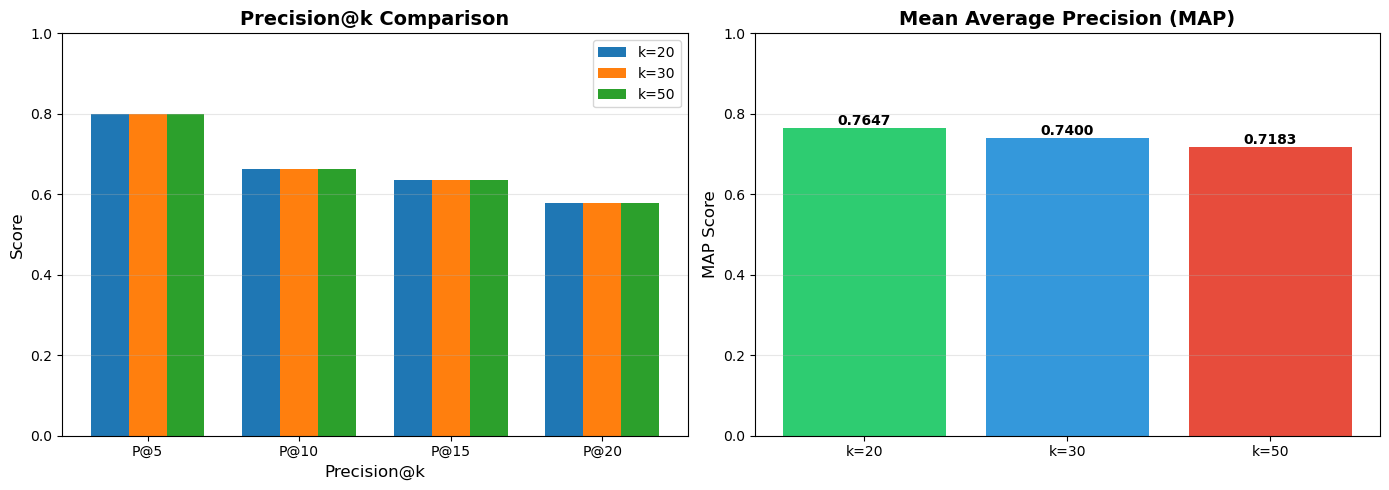


ΤΕΛΙΚΑ ΑΠΟΤΕΛΕΣΜΑΤΑ - PHASE 1 BASELINE

ElasticSearch Index: ir2025_bm25
Model: BM25 with English Analyzer
Number of Documents: 18,316
Number of Queries: 10

------------------------------------------------------------
             MAP      P@5     P@10     P@15     P@20
Run (k)                                             
20      0.764668 0.800000 0.663636 0.636364 0.577273
30      0.740046 0.800000 0.663636 0.636364 0.577273
50      0.718269 0.800000 0.663636 0.636364 0.577273
------------------------------------------------------------

📊 Key Performance Indicators:
  • Best MAP:  0.7647 (76.47%)
  • Best P@5:  0.8000 (80.00%)
  • Best P@10: 0.6636 (66.36%)



In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Create visualizations of the results
if all_results:
    # 1. Bar chart of P@k metrics for different k values
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Left plot: Precision@k for each run
    ax1 = axes[0]
    x_pos = np.arange(len(K_VALUES_EVAL))
    width = 0.25
    
    for i, k_run in enumerate(K_VALUES_RUN):
        if k_run in all_results:
            p_values = [all_results[k_run].get(f'P@{k}', 0) for k in K_VALUES_EVAL]
            ax1.bar(x_pos + i * width, p_values, width, label=f'k={k_run}')
    
    ax1.set_xlabel('Precision@k', fontsize=12)
    ax1.set_ylabel('Score', fontsize=12)
    ax1.set_title('Precision@k Comparison (trec_eval)', fontsize=14, fontweight='bold')
    ax1.set_xticks(x_pos + width)
    ax1.set_xticklabels([f'P@{k}' for k in K_VALUES_EVAL])
    ax1.legend()
    ax1.grid(axis='y', alpha=0.3)
    ax1.set_ylim(0, 1)
    
    # Right plot: MAP comparison
    ax2 = axes[1]
    map_values = [all_results[k].get('MAP', 0) for k in K_VALUES_RUN if k in all_results]
    colors = ['#2ecc71', '#3498db', '#e74c3c']
    bars = ax2.bar([f'k={k}' for k in K_VALUES_RUN if k in all_results], 
                   map_values, color=colors[:len(map_values)])
    
    ax2.set_ylabel('MAP Score', fontsize=12)
    ax2.set_title('Mean Average Precision (trec_eval)', fontsize=14, fontweight='bold')
    ax2.grid(axis='y', alpha=0.3)
    ax2.set_ylim(0, 1)
    
    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.4f}',
                ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    plt.tight_layout()
    plt.savefig(RESULTS_DIR / 'evaluation_results_trec.png', dpi=150, bbox_inches='tight')
    print(f"\n✓ Visualization saved to: {RESULTS_DIR / 'evaluation_results_trec.png'}")
    plt.show()
    
    # 2. Summary table
    print("\n" + "="*60)
    print("ΤΕΛΙΚΑ ΑΠΟΤΕΛΕΣΜΑΤΑ - PHASE 1 BASELINE (trec_eval)")
    print("="*60)
    print(f"\nElasticSearch Index: {ES_INDEX}")
    print(f"Model: BM25 with English Analyzer")
    print(f"Number of Documents: 18,316")
    print(f"Number of Queries: 10")
    print(f"Evaluation Tool: trec_eval (Official NIST Tool)")
    print("\n" + "-"*60)
    print(results_df.to_string(float_format=lambda x: f'{x:.6f}'))
    print("-"*60)
    
    # Best scores summary
    print("\n📊 Key Performance Indicators:")
    best_map = max(all_results[k].get('MAP', 0) for k in all_results)
    best_p5 = max(all_results[k].get('P@5', 0) for k in all_results)
    best_p10 = max(all_results[k].get('P@10', 0) for k in all_results)
    
    print(f"  • Best MAP:  {best_map:.4f} ({best_map*100:.2f}%)")
    print(f"  • Best P@5:  {best_p5:.4f} ({best_p5*100:.2f}%)")
    print(f"  • Best P@10: {best_p10:.4f} ({best_p10*100:.2f}%)")
    print("\n" + "="*60)
else:
    print("No results to visualize. Make sure to run the evaluation first.")


---

### Προαπαιτούμενα:
1. **ElasticSearch** πρέπει να τρέχει στο `http://localhost:9200`
   ```
   cd elasticsearch\elasticsearch-9.1.5-windows-x86_64\elasticsearch-9.1.5\bin
   .\elasticsearch.bat
   ```
2. **Python packages**: `pip install pandas elasticsearch requests tqdm matplotlib`

3. **trec_eval**: Το επίσημο εργαλείο αξιολόγησης TREC πρέπει να βρίσκεται στο `trec_eval/trec_eval.exe`

### Αρχεία που δημιουργούνται:
- `data/documents.ndjson` - Προεπεξεργασμένα έγγραφα
- `results_k20.txt`, `results_k30.txt`, `results_k50.txt` - Αποτελέσματα queries (TREC format)
- `evaluation_trec_k20.txt`, `evaluation_trec_k30.txt`, `evaluation_trec_k50.txt` - Επίσημα αποτελέσματα trec_eval
- `evaluation_results_trec.png` - Γραφήματα αποτελεσμάτων

---
